# Intro
In this notebook, we study two things
- The impact of the Hyperparameters on EigenFaces
- The impact of transformations on EigenFaces using the most favorable conditions

# Hyperparameters

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from vic.dataloader import load_orl, load_yale, make_fixed_test_indices, split_with_fixed_test
from vic.models import Eigenfaces
import cv2

In [34]:
orl = load_orl("../data/ORL")
yale = load_yale("../data/Yale")

test_idx_orl, pool_idx_orl = make_fixed_test_indices(orl, n_test=3, seed=0)
test_idx_yale, pool_idx_yale = make_fixed_test_indices(yale, n_test=3, seed=0)

Xtr_orl, ytr_orl, Xte_orl, yte_orl = split_with_fixed_test(orl, test_idx_orl, pool_idx_orl, 6, seed=0)
Xtr_yale, ytr_yale, Xte_yale, yte_yale = split_with_fixed_test(yale, test_idx_yale, pool_idx_yale, 6, seed=0)

In [ ]:
def evaluate_eigenfaces_mean_std(
    data,
    test_idx,
    pool_idx,
    Ks,
    n_train=7,
    n_exp=10,
    seed_master=0,
):
    rng = np.random.RandomState(seed_master)

    accs = np.zeros((len(Ks), n_exp))

    for exp in tqdm(range(n_exp)):
        seed = rng.randint(0, 10_000)

        Xtr, ytr, Xte, yte = split_with_fixed_test(data, test_idx, pool_idx, n_train=n_train, seed=seed)

        for i, K in enumerate(Ks):
            model = Eigenfaces(K)
            model.fit(Xtr, ytr)
            y_pred = model.predict(Xte)
            accs[i, exp] = (y_pred == yte).mean()

    return accs.mean(axis=1), accs.std(axis=1)

In [ ]:
Ks = [5, 10, 20, 40, 80, 100]

mean_orl, std_orl = evaluate_eigenfaces_mean_std(
    orl, test_idx_orl, pool_idx_orl, Ks, n_train=7, n_exp=5, seed_master=0
)

mean_yale, std_yale = evaluate_eigenfaces_mean_std(
    yale, test_idx_yale, pool_idx_yale, Ks, n_train=7, n_exp=5, seed_master=0
)

100%|██████████| 5/5 [01:38<00:00, 19.77s/it]


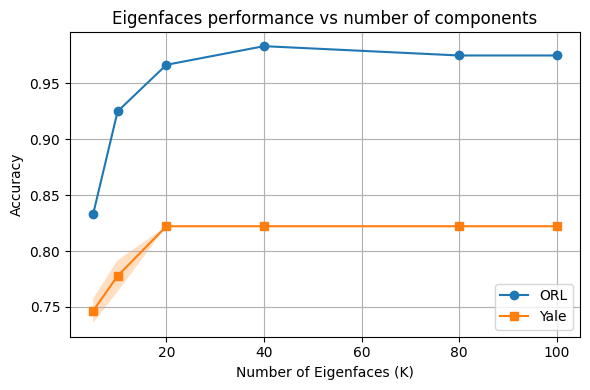

In [19]:
plt.figure(figsize=(6, 4))

# ORL
plt.plot(Ks, mean_orl, marker="o", label="ORL")
plt.fill_between(Ks, mean_orl - std_orl, mean_orl + std_orl, alpha=0.25)

# Yale
plt.plot(Ks, mean_yale, marker="s", label="Yale")
plt.fill_between(Ks, mean_yale - std_yale, mean_yale + std_yale, alpha=0.25)

plt.xlabel("Number of Eigenfaces (K)")
plt.ylabel("Accuracy")
plt.title("Eigenfaces performance vs number of components")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Transformations

In [35]:
orl = load_orl("../data/ORL")
yale = load_yale("../data/Yale")

test_idx_orl, pool_idx_orl = make_fixed_test_indices(orl, n_test=3, seed=0)
test_idx_yale, pool_idx_yale = make_fixed_test_indices(yale, n_test=3, seed=0)

Xtr_orl, ytr_orl, Xte_orl, yte_orl = split_with_fixed_test(orl, test_idx_orl, pool_idx_orl, 6, seed=0)
Xtr_yale, ytr_yale, Xte_yale, yte_yale = split_with_fixed_test(yale, test_idx_yale, pool_idx_yale, 6, seed=0)

In [ ]:
def identity(x):
    return x


def gaussian_blur(x, k=11):
    return cv2.GaussianBlur(x, (k, k), 0)


def jitter_and_sp(x, alpha=1.4, beta=30, p=0.05):
    # brightness / contrast jitter
    x2 = x.astype(np.float32) * alpha + beta
    x2 = np.clip(x2, 0, 255).astype(np.uint8)

    # salt & pepper
    mask = np.random.rand(*x.shape)
    x2[mask < p / 2] = 0
    x2[mask > 1 - p / 2] = 255
    return x2


def random_rotation(x, max_angle=20):
    angle = np.random.uniform(-max_angle, max_angle)
    h, w = x.shape
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.0)
    return cv2.warpAffine(x, M, (w, h), borderMode=cv2.BORDER_REFLECT)


def random_crop_resize(x, keep=0.75):
    h, w = x.shape
    ch, cw = int(h * keep), int(w * keep)

    y0 = np.random.randint(0, h - ch)
    x0 = np.random.randint(0, w - cw)

    crop = x[y0 : y0 + ch, x0 : x0 + cw]
    return cv2.resize(crop, (w, h), interpolation=cv2.INTER_LINEAR)


transformations = {
    "None": identity,
    "Gaussian blur (11x11)": gaussian_blur,
    "Jitter + salt&pepper": jitter_and_sp,
    "Random rotation (±20°)": random_rotation,
    "Random crop (75%)": random_crop_resize,
}

In [ ]:
def evaluate_eigenfaces_with_transform(
    data,
    test_idx,
    pool_idx,
    K,
    transform,
    n_train=7,
    n_exp=10,
    seed_master=0,
):
    rng = np.random.RandomState(seed_master)
    accs = np.zeros(n_exp)

    for exp in range(n_exp):
        seed = rng.randint(0, 10_000)

        Xtr, ytr, Xte, yte = split_with_fixed_test(data, test_idx, pool_idx, n_train=n_train, seed=seed)

        Xtr_t = np.stack([transform(x) for x in Xtr])
        Xte_t = np.stack([transform(x) for x in Xte])

        model = Eigenfaces(K)
        model.fit(Xtr_t, ytr)
        y_pred = model.predict(Xte_t)

        accs[exp] = (y_pred == yte).mean()

    return accs.mean(), accs.std()

In [ ]:
results_orl = {}
results_yale = {}

for name, tf in transformations.items():
    results_orl[name] = evaluate_eigenfaces_with_transform(
        orl, test_idx_orl, pool_idx_orl, K=40, transform=tf, n_exp=5
    )

    results_yale[name] = evaluate_eigenfaces_with_transform(
        yale, test_idx_yale, pool_idx_yale, K=40, transform=tf, n_exp=5
    )

In [ ]:
def plot_transform_results_side_by_side(results_orl, results_yale, title):
    labels = list(results_orl.keys())
    y = np.arange(len(labels))

    # Extract stats
    mean_orl = np.array([results_orl[k][0] for k in labels])
    std_orl = np.array([results_orl[k][1] for k in labels])

    mean_yale = np.array([results_yale[k][0] for k in labels])
    std_yale = np.array([results_yale[k][1] for k in labels])

    # Baselines ("None")
    baseline_orl = results_orl["None"][0]
    baseline_yale = results_yale["None"][0]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # --- ORL ---
    axes[0].errorbar(mean_orl, y, xerr=std_orl, fmt="o", capsize=4)
    axes[0].axvline(baseline_orl, linestyle="--", linewidth=1, color="gray", label="No transform")
    axes[0].set_title("ORL")
    axes[0].set_xlabel("Accuracy")
    axes[0].set_yticks(y)
    axes[0].set_yticklabels(labels)
    axes[0].grid(axis="x", alpha=0.3)
    axes[0].legend()

    # --- Yale ---
    axes[1].errorbar(mean_yale, y, xerr=std_yale, fmt="o", capsize=4)
    axes[1].axvline(baseline_yale, linestyle="--", linewidth=1, color="gray", label="No transform")
    axes[1].set_title("Yale")
    axes[1].set_xlabel("Accuracy")
    axes[1].grid(axis="x", alpha=0.3)
    axes[1].legend()

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

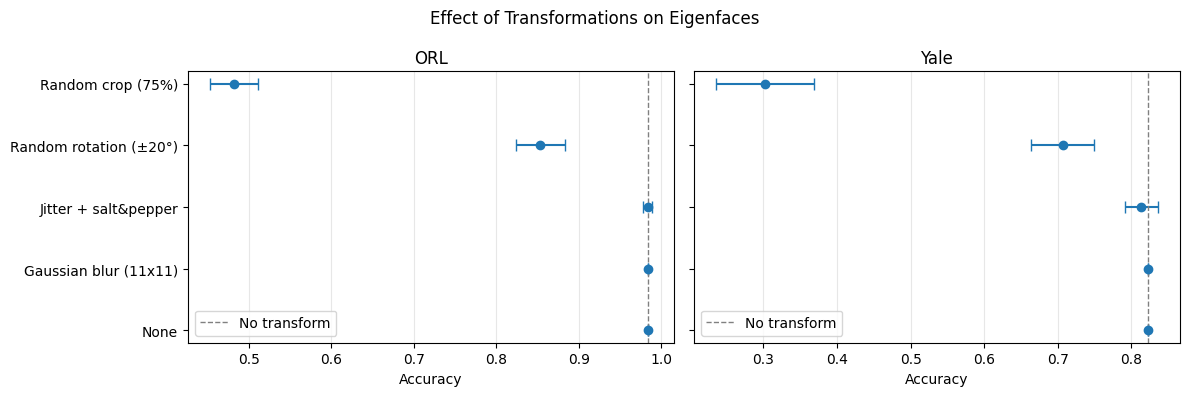

In [ ]:
plot_transform_results_side_by_side(
    results_orl, results_yale, title="Effect of Transformations on Eigenfaces"
)

In [57]:
def evaluate_severity_curve(
    data, test_idx, pool_idx, K, transform_factory, severities, n_train=7, n_exp=5, seed_master=0
):
    means = []
    stds = []

    for s in severities:
        transform = transform_factory(s)

        m, sd = evaluate_eigenfaces_with_transform(
            data,
            test_idx,
            pool_idx,
            K=K,
            transform=transform,
            n_train=n_train,
            n_exp=n_exp,
            seed_master=seed_master,
        )
        means.append(m)
        stds.append(sd)

    return np.array(means), np.array(stds)


def plot_severity_curve(severities, mean_orl, std_orl, mean_yale, std_yale, xlabel, title):
    plt.figure(figsize=(6, 4))

    plt.plot(severities, mean_orl, marker="o", label="ORL")
    plt.fill_between(severities, mean_orl - std_orl, mean_orl + std_orl, alpha=0.25)

    plt.plot(severities, mean_yale, marker="s", label="Yale")
    plt.fill_between(severities, mean_yale - std_yale, mean_yale + std_yale, alpha=0.25)

    plt.xlabel(xlabel)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

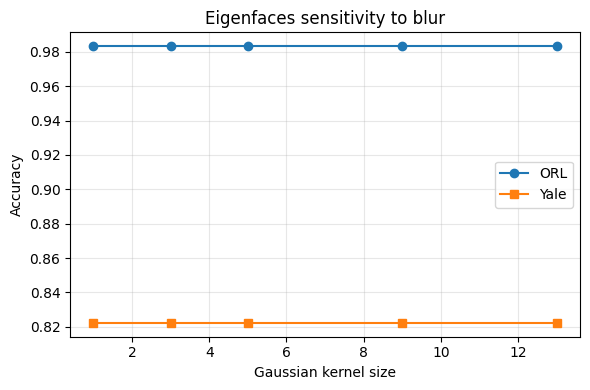

In [58]:
blur_ks = [1, 3, 5, 9, 13]


def blur_factory(k):
    if k == 1:
        return identity
    return lambda x: cv2.GaussianBlur(x, (k, k), 0)


orl_mean_blur, orl_std_blur = evaluate_severity_curve(
    orl, test_idx_orl, pool_idx_orl, 40, blur_factory, blur_ks
)

yale_mean_blur, yale_std_blur = evaluate_severity_curve(
    yale, test_idx_yale, pool_idx_yale, 40, blur_factory, blur_ks
)
plot_severity_curve(
    blur_ks,
    orl_mean_blur,
    orl_std_blur,
    yale_mean_blur,
    yale_std_blur,
    xlabel="Gaussian kernel size",
    title="Eigenfaces sensitivity to blur",
)

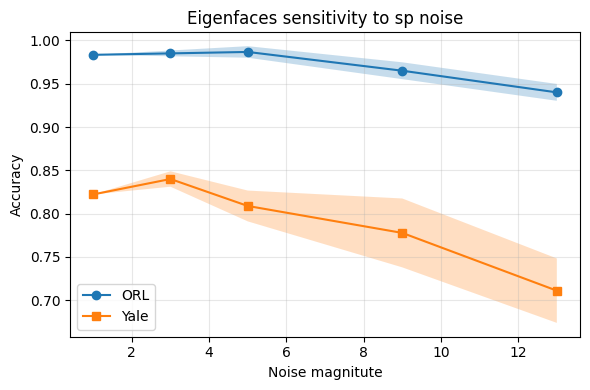

In [ ]:
ps = [0.0, 0.02, 0.05, 0.10, 0.15]


def jitter_sp_factory(p):
    if p == 0.0:
        return identity
    return lambda x: jitter_and_sp(x, alpha=1.4, beta=30, p=p)


orl_mean_noise, orl_std_noise = evaluate_severity_curve(
    orl, test_idx_orl, pool_idx_orl, 40, jitter_sp_factory, ps
)

yale_mean_noise, yale_std_noise = evaluate_severity_curve(
    yale, test_idx_yale, pool_idx_yale, 40, jitter_sp_factory, ps
)

plot_severity_curve(
    ps,
    orl_mean_noise,
    orl_std_noise,
    yale_mean_noise,
    yale_std_noise,
    xlabel="Noise magnitute",
    title="Eigenfaces sensitivity to sp noise",
)

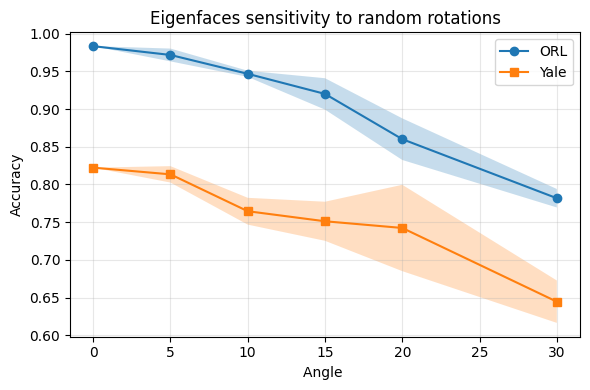

In [64]:
angles = [0, 5, 10, 15, 20, 30]


def rotation_factory(max_angle):
    if max_angle == 0:
        return identity
    return lambda x: random_rotation(x, max_angle=max_angle)


orl_mean_rot, orl_std_rot = evaluate_severity_curve(
    orl, test_idx_orl, pool_idx_orl, 40, rotation_factory, angles
)

yale_mean_rot, yale_std_rot = evaluate_severity_curve(
    yale, test_idx_yale, pool_idx_yale, 40, rotation_factory, angles
)

plot_severity_curve(
    angles,
    orl_mean_rot,
    orl_std_rot,
    yale_mean_rot,
    yale_std_rot,
    xlabel="Angle ",
    title="Eigenfaces sensitivity to random rotations",
)

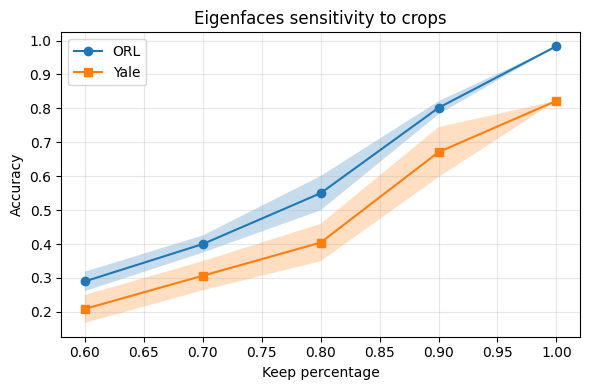

In [66]:
keeps = [0.6, 0.7, 0.8, 0.9, 1]


def crop_factory(keep):
    if keep == 1.0:
        return identity
    return lambda x: random_crop_resize(x, keep=keep)


orl_mean_crop, orl_std_crop = evaluate_severity_curve(
    orl, test_idx_orl, pool_idx_orl, 40, crop_factory, keeps
)

yale_mean_crop, yale_std_crop = evaluate_severity_curve(
    yale, test_idx_yale, pool_idx_yale, 40, crop_factory, keeps
)
plot_severity_curve(
    keeps,
    orl_mean_crop,
    orl_std_crop,
    yale_mean_crop,
    yale_std_crop,
    xlabel="Keep percentage",
    title="Eigenfaces sensitivity to crops",
)